In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from keras.layers import Conv2D,MaxPool2D,LeakyReLU,Flatten,Dense,Input,Dropout,BatchNormalization
from keras.models import Model
import keras.backend as K
from keras.losses import categorical_crossentropy
from keras.optimizers import Nadam
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
def convert_to_one_hot(Y, C):
    Y = Y.astype('int')
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [3]:
data1 = pd.read_csv('train.csv')
data2 = pd.read_csv('test.csv')
data1 = np.array(data1)
data2 = np.array(data2)
X_train = data1[:,1::]/255
X_test = data2[:,:]/255
n1 = X_train.shape[0]
n2 = X_test.shape[0]
X_train = np.reshape(X_train,(n1,28,28,1))
X_test = np.reshape(X_test,(n2,28,28,1))
X_train = np.pad(X_train,((0,0),(2,2),(2,2),(0,0)),'constant')
Y_train = data1[:,np.newaxis,0]
X_test = np.pad(X_test,((0,0),(2,2),(2,2),(0,0)),'constant')
Y_train = convert_to_one_hot(Y_train,10).T
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(42000, 32, 32, 1)
(42000, 10)
(28000, 32, 32, 1)


In [4]:
batch_size = 64

In [5]:
def MODEL():
    X_in = Input(shape=(32,32,1),name='image_in')
    
    X = Conv2D(filters=32,kernel_size=3)(X_in)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = Conv2D(filters=32,kernel_size=3)(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = Conv2D(filters=32,strides=2,kernel_size=5,padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = Dropout(0.4)(X)
    
    X = Conv2D(filters=64,kernel_size=3)(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = Conv2D(filters=64,kernel_size=3)(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = Conv2D(filters=64,strides=2,kernel_size=5,padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = Dropout(0.4)(X)
    
    X = Flatten()(X)
    
    X = Dense(128)(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = Dropout(0.4)(X)
    
    X = Dense(10,activation='softmax')(X)
    
    model = Model(inputs=X_in,outputs=X)
    return model

In [6]:
def cat_loss(target, output, axis=-1):
    output_dimensions = list(range(len(output.shape)))
    output /= np.sum(output, axis)[:,None]
    output = np.clip(output, K.epsilon(), 1. - K.epsilon())
    return -np.mean(np.sum(target * np.log(output), axis))

In [7]:
def np_count(t, val):
    elements_equal_to_value = np.equal(t, val)
    as_ints = elements_equal_to_value.astype('int32')
    count = np.sum(as_ints)
    return count

In [11]:
num_epochs = 25
batch_step = -1
min_test_loss=99.0
loss_lst = []
acc_lst = []
indeces = np.array(range(X_train.shape[0]))
num_batches = int(np.ceil(X_train.shape[0]/batch_size))
model = MODEL()
model.compile(optimizer=Nadam(),loss=categorical_crossentropy)
for epoch in range(num_epochs):
    np.random.shuffle(indeces)
    X_train_s = np.copy(X_train[indeces])
    Y_train_s = np.copy(Y_train[indeces])
    print('Epoch {}/{}'.format(epoch+1,num_epochs))
    for bi in range(num_batches):
        batch_step += 1
        a = bi*batch_size
        b = (bi+1)*batch_size
        batch_loss = model.train_on_batch(X_train_s[a:b],Y_train_s[a:b])
    train_pred = model.predict(X_train)
    loss = cat_loss(Y_train,train_pred)
    y_hat = np.argmax(train_pred,1)
    yy = np.argmax(Y_train,1)
    correct_pred = np.equal(y_hat,yy)
    cnt = np_count(correct_pred, True)
    acc = cnt/X_train.shape[0]
    print('loss: ',loss)
    print('accuracy: ',acc)
    loss_lst.append(loss)
    acc_lst.append(acc)

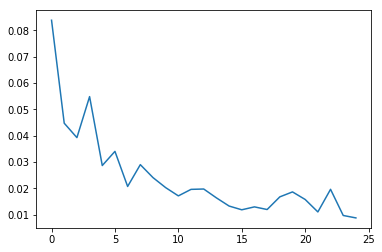

In [11]:
plt.plot(loss_lst)

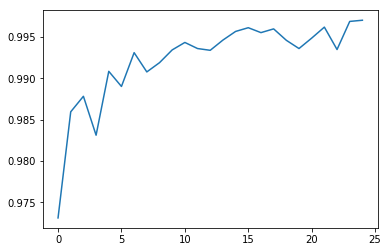

In [12]:
plt.plot(acc_lst)

In [13]:
Y_test = model.predict(X_test)
Y_test = np.argmax(Y_test,1)
Y_test=Y_test.reshape(28000,1)
c = np.array([[i+1 for i in range(28000)]]).T
ans=np.concatenate((c,Y_test),axis=1)
df = pd.DataFrame(ans,columns=['ImageId','Label'])
df.to_csv('ans.csv',index=False)